This notebook will try to create a NN model that can predict stock data for Tesla stock (Closing price predictions).

In [1]:
# Delete this part if running Jupyter Notebook
from google.colab import files
files.upload()

Saving tesla-stock-data.csv to tesla-stock-data.csv


{'tesla-stock-data.csv': b'Date, Close/Last, Volume, Open, High, Low\n01/27/2021, $864.16, 27333960, $870.35, $891.5, $858.66\n01/26/2021, $883.09, 23131600, $891.38, $895.9, $871.6\n01/25/2021, $880.8, 41173400, $855, $900.4, $838.8201\n01/22/2021, $846.64, 20066500, $834.31, $848, $828.62\n01/21/2021, $844.99, 20598130, $855, $855.7199, $841.4201\n01/20/2021, $850.45, 25665880, $858.74, $859.5, $837.28\n01/19/2021, $844.55, 25366980, $837.8, $850, $833\n01/15/2021, $826.16, 38777600, $852, $859.9, $819.1\n01/14/2021, $845, 31266330, $843.39, $863, $838.75\n01/13/2021, $854.41, 33312500, $852.76, $860.47, $832\n01/12/2021, $849.44, 46270720, $831, $868, $827.34\n01/11/2021, $811.19, 59554150, $849.4, $854.43, $803.6222\n01/08/2021, $880.02, 75055530, $856, $884.49, $838.39\n01/07/2021, $816.04, 51498950, $777.63, $816.99, $775.2\n01/06/2021, $755.98, 44699970, $758.49, $774, $749.1\n01/05/2021, $735.11, 32245170, $723.66, $740.84, $719.2\n01/04/2021, $729.77, 48638190, $719.46, $744.4

# 1. Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix,classification_report,roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
plt.rcParams.update({'font.size': 13})


# 2. Dataset and DatasetLoader Classes

In [4]:
'''
# Manual way to get the time lag
l = [1,2,3,4,5]
input = 2 #so given the last 2 days, predict the next day
output = 1

x_out = []
y_out = []
for counter in range(0,len(l)-input-output+1):
  x_out.append(l[counter : counter + input])
  y_out.append(l[counter+input : counter + input + output])
print(x_out)
print(y_out)
'''

'\n# Manual way to get the time lag\nl = [1,2,3,4,5]\ninput = 2 #so given the last 2 days, predict the next day\noutput = 1\n\nx_out = []\ny_out = []\nfor counter in range(0,len(l)-input-output+1):\n  x_out.append(l[counter : counter + input])\n  y_out.append(l[counter+input : counter + input + output])\nprint(x_out)\nprint(y_out)\n'

In [81]:
#An important thing to note is that __getitem__() returns a specific type for a single data point (like a tensor, numpy array etc.)
# The get item needs to return other things now, since we need to set a time lag
class TeslaDataset(Dataset):
  '''
  Create dataset from CSV. Will use this to create train dataset and test dataset. 
  '''
  def __init__(self, df,target,n_in,n_out,dataset_type, normalize = False, normalizer = None):
    '''
    Parameters:
    df -- dataframe to convert into dataset
    target -- target column to use for time series
    n_in -- rolling window size || n_in = 3 means predictions made on last 3 days
    n_out -- output size || n_out =3 means that model will predict next 3 days.
    normalize -- Whether or not to normalize
    dataset_type -- "train" or "test"
    normalizer -- Only required if dataset_type is "test" and normalize == True. Will use the train normalizer for transforming, no refitting is used.
    '''

    df,X,Y,dropped,dropped_df = self.preprocess(df,target,n_in,n_out,dataset_type,normalize,normalizer)

    self.df = df
    # Take tensors from output 
    self.X = torch.from_numpy(X)
    self.Y = torch.from_numpy(Y)
    self.dropped = dropped
    self.dropped_df = dropped_df

  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    return (self.X[idx],self.Y[idx])
  
  def preprocess(self, df,target,n_in,n_out,dataset_type, normalize = False, normalizer = None):
    '''
    Main function to preprocess dataframe
    '''
    # Convert the datatypes to floats
    df = self.convert_to_float(df)
    df = df.reset_index(drop=True)
    # Normalize data (or not)
    if normalize == True:
      if dataset_type == "train":
        self.normalizer, target_data  = self.normalize(df[target].values)
      elif dataset_type == "test":
        self.normalizer = normalizer
        target_data = self.normalizer.transform(df[target].values.reshape(-1,1))
    elif normalize == False:
      self.normalizer = None
      target_data = df[target].values

    # Convert data into time lag
    X,Y,dropped = self.convert_to_time_lag(target_data, n_in,n_out)

    dropped_df = df.drop(index = dropped)

    return df,X,Y,dropped,dropped_df

  ####################
  # Helper Functions #
  ####################
  def convert_to_float(self,df):
    corrections = ['Close','Open','High','Low']
    for c in corrections:
      df[c] = df[c].apply(lambda s : float(str(s)[2:]))
    return df
  
  def normalize(self,data):
    normalizer = MinMaxScaler()
    data = normalizer.fit_transform(data.reshape(-1,1))
    return normalizer,data
  

  def get_normalizer(self):
    return self.normalizer


  def convert_to_time_lag(self,data, n_in=1, n_out=1):
    '''
    Function to convert into time lag, using pandas way, inspired by:
    https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/

    data - a list of numbers
    n_in - number of days to use as the window size
    n_out - target number of days to predict
    '''
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    # this way it append the shifts from df.shift(n_in),df.shift(n_in-1), onwards.
    # So the first row of the first column would be at 0-n_in days
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i).values) #shifts down
    # output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i).values) #shifts up
    
    # Concat and drop na
    df = pd.DataFrame(np.concatenate(cols, axis=1))
    dropped_df = df.dropna()
    dropped_index = df[~df.index.isin(dropped_df.index)].index

    # Just extract the x and y values
    x = dropped_df.iloc[:,:n_in].values
    y = dropped_df.iloc[:,n_in:].values

    return x,y,dropped_index


In [82]:
  df = pd.read_csv(df_path)
  df.columns= ['Date','Close','Volume','Open','High','Low']

  # Reorder dataframe to ascending order (from earliest to most recent dates)
  df = df.iloc[::-1,:]
  df.reset_index(drop=True,inplace=True)
  # Split dataframe up into train and test
  df_train, df_test = tts(df, test_size=test_size, random_state=2021, shuffle=False)

  # Create datasets
  train_dataset = TeslaDataset(df = df_train,
                              target = target,
                              n_in = window_size,
                              n_out = out_size,
                              normalize = normalize,
                              dataset_type='train'
                              )
  test_dataset = TeslaDataset(df = df_test,
                              target = target,
                              n_in = window_size,
                              n_out = out_size, 
                              normalize = normalize,
                              normalizer = train_dataset.get_normalizer(),
                              dataset_type='test'
                              )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [83]:
test_dataset.df

,Date,Close,Volume,Open,High,Low
0,07/30/2019,48.452,40545070,46.58,48.6720,46.4360
1,07/31/2019,48.322,45891040,48.60,49.3360,47.3300
2,08/01/2019,46.770,41297580,48.53,48.9020,46.3540
3,08/02/2019,46.868,30682405,46.27,47.2540,45.8460
4,08/05/2019,45.664,35141395,45.92,46.2735,45.1550
...,...,...,...,...,...,...
373,01/21/2021,844.990,20598130,855.00,855.7199,841.4201
374,01/22/2021,846.640,20066500,834.31,848.0000,828.6200
375,01/25/2021,880.800,41173400,855.00,900.4000,838.8201
376,01/26/2021,883.090,23131600,891.38,895.9000,871.6000


In [84]:
test_dataset.dropped_df

,Date,Close,Volume,Open,High,Low
7,08/08/2019,47.660,26371745,46.8900,47.9600,46.5300
8,08/09/2019,47.002,19491220,47.2108,47.7920,46.7620
9,08/12/2019,45.802,23319685,46.5980,47.1540,45.7500
10,08/13/2019,47.000,24344990,45.7620,47.2000,45.5100
11,08/14/2019,43.924,47812955,46.2420,46.3000,43.3380
...,...,...,...,...,...,...
371,01/19/2021,844.550,25366980,837.8000,850.0000,833.0000
372,01/20/2021,850.450,25665880,858.7400,859.5000,837.2800
373,01/21/2021,844.990,20598130,855.0000,855.7199,841.4201
374,01/22/2021,846.640,20066500,834.3100,848.0000,828.6200


# 3. Model Definition Class

In [6]:
# Defining the model
class forecast_model_simple(nn.Module):
  '''
  This is the class for the forecasting model. Will use simple 3-layer neural network. [7,10,1]
  '''
  def __init__(self,n_in,n_out):
    super(forecast_model_simple,self).__init__()
    self.fc1 = nn.Linear(in_features = n_in,out_features = 10)
    self.fc2 = nn.Linear(in_features = 10, out_features = n_out)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


#4. Model Training Function

In [7]:
def fit(model,num_epochs,dataloader,criterion,optimizer):
  '''
  Fitting the model based on the train set. Specify the dataloader used, as well as the size of the dataset.

  model - model to be fitted
  dataloader - dataloader to use
  num_epochs - number of epochs
  '''
  # Train the model
  dataset_length = len(dataloader.dataset)
  losses = []
  for i in range(num_epochs):
    print("-"*25)
    print(f"Currently training for epoch {i+1}.")
    running_loss = 0
    for idx,data in enumerate(dataloader):
      # Get the data
      # Shape of data = (batch_size, dim(x))
      x,y = data 
      if idx == 0:
        print(x.size)
      y = y.float()

      # Zero the gradients
      optimizer.zero_grad()

      # Forward Pass
      y_hat = model(x.float())
      # Get Loss, use RMSE
      loss = torch.sqrt(criterion(y_hat,y))
      # Backward Pass and Optimize
      loss.backward() #Will automatically get gradients for the batch
      optimizer.step()

      # Get the loss and multiply it by the number of samples in the batch
      running_loss += loss.item() * x.shape[0] 

    epoch_loss = running_loss / dataset_length
    print(f"Epoch {i+1} loss : {epoch_loss}")
    losses.append(epoch_loss)
  print("Training finished.")
  return losses



In [8]:
def plot_model_loss(train_loss,num_epochs):
  fig,ax = plt.subplots(figsize = (10,6))
  plt.plot(train_loss,label='Training loss')
  plt.xticks(np.arange(0,num_epochs,1))
  ax.set_xticklabels(np.arange(1,num_epochs+1,1))
  plt.title('Loss curve for training')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()


If we need to save the model:

In [9]:
# Save Model
#torch.save(model.state_dict(),"LR_model")

In [10]:
# Load Model
#model = LogisticRegression()
#model.load_state_dict(torch.load(PATH))

#5. Model Evaluation function

Use torch.Tensor.item() to get a Python number from a tensor containing a single value:

In [54]:
def predict(model,dataloader, normalize = False,normalizer = None,criterion = None,output_size = 1):
  '''
  Parameters: 
  model -- model for prediction
  dataloader -- loads data for model to predict on
  normalize -- True or False
  normalizer -- Only required if normalize is true. Uses this to inverse transform predictions, should use the normalizer for training datset
  '''

  num_samples = 0
  with torch.no_grad():
    running_loss = 0
    actual_predictions = np.array([])
    for idx,data in enumerate(dataloader):

      # Handle cases where multi output is needed.
      # So if I forecast 3 days, I take (t+1,t+2,t+3) to be one sample
      # If originally I have 30 days to forecast, with an out_size of 3, then will forecast in 
      # 3 day intervals, so (1,2,3), (4,5,6), etc.
      # That yields sample size of 10. So take RMSE of each sample, and average over 10.
      if idx % output_size == 0: 
        x,y = data
        # Get predictions
        pred = model(x.type(torch.float32))
        
        # Sum up the loss
        running_loss += torch.sqrt(criterion(y,pred)).item()

        # Append predictions to output
        actual_predictions = np.append(actual_predictions,pred.numpy().squeeze())

        # Increment the num_samples by the batch size. In default case for test dataset loader, this would be 1
        num_samples += x.size()[0]

  # Undo the normalization on the output to get actual prediction values
  if normalize == True:
    actual_predictions = normalizer.inverse_transform(actual_predictions.reshape(-1,1))

  # Get the average of running loss
  loss = running_loss/num_samples
  print(f"Shape of actual_predictions is {actual_predictions.shape}")

  return loss,actual_predictions 


In [12]:
def plot_results(pred_dates,true_dates,pred,true,normalize,save_path):
  if normalize == True:
    norma = "Normalized"
  else:
    norma = "UnNormalized"
  fig,ax = plt.subplots(figsize = (12,8))
  plt.plot(pred_dates, pred , label = 'Predictions')
  plt.plot(true_dates,true,label = 'Actual',alpha=0.5)
  

  plt.title(f"Model Predictions with {save_path}")
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()
  plt.draw()
  fig.savefig(save_path)


In [65]:
def evaluate(model,dataloader,test_dataset,train_dataset,df,criterion,normalize = False,normalizer = None,save_path = None,output_size = 1):
  '''
  Function to evaluate model. Will produce classification report, Confusion Matrix, and finally will show ROC-AUC.

  Parameters:
  model -- model to evaluate
  dataloader -- the dataloader used. Should be test loader
  test_dataset -- test dataset used
  train_dataset -- training dataset
  df -- dataframe used for the time series prediction
  normalize -- True or False
  '''

  # Prepare predictions

  # Get model predictions. 
  print(f"passing criterion to predict function",{criterion})
  loss,pred = predict(model,dataloader,normalize, normalizer,criterion,output_size)
  print(f"The average RMSE of predictions is : {loss}")

  # Convert to 1 dimension
  pred = pred.squeeze()
  
  # Also get corresponding dates for the predictions
  pred_dates = pd.to_datetime(test_dataset.dropped_df['Date'])

  # Prepare ground truth data
  true = np.append(train_dataset.df[target].values,test_dataset.df[target].values)
  true = true.squeeze()  

  # Make the dates into datetime for ground truth
  true_dates = pd.to_datetime(df.Date)

  #####################################################
  # Plotting results from start date to end date of entire dataframe
  plot_results(pred_dates,true_dates,pred,true,normalize,save_path)

  #####################################################
  # Plot only prediction period
  alt = save_path + " (magnified)"
  plot_results(pred_dates = pred_dates,
               true_dates = pd.to_datetime(test_dataset.df['Date']),
               pred = pred,
               true = test_dataset.df[target].values,
               normalize = normalize,
               save_path =alt
               )
  return loss


# 6. Main Function

In [66]:
def main(df_path,window_size,out_size,target,test_size,training_batch_size,test_batch_size,normalize,num_epochs,lr,save_path,optim_type,weight_decay = 0):
  '''
  Main function to test models out. Encapsulates entire process from reading in dataframe, preparing datasets, creating model, etc.

  Parameters:
 
  df_path -- path to dataframe
  window_size -- rolling window size || window_size = 3 means predictions made on last 3 days
  out_size -- output size || out_size = 3 means that model will predict next 3 days.
  target -- target column to use for time series prediction
  test_size -- fraction of df to use as test data
  training_batch_size,test_batch_size -- # of samples to include in each batch respectively
  normalize -- Whether or not to normalize (True or False)
  num_epochs -- Number of epochs to train for
  lr -- learning rate
  save_path -- path to save the graph of model predictions (the plot)
  optim_type -- optimizer type. At the moment on can use "ADAM" or "SGD"
  weight_decay -- L2 Regularization. If none is to be used set this to 0
  '''
  df = pd.read_csv(df_path)
  df.columns= ['Date','Close','Volume','Open','High','Low']

  # Reorder dataframe to ascending order (from earliest to most recent dates)
  df = df.iloc[::-1,:]
  df.reset_index(drop=True,inplace=True)

  # Split dataframe up into train and test
  df_train, df_test = tts(df, test_size=test_size, random_state=2021, shuffle=False)

  # Create datasets
  train_dataset = TeslaDataset(df = df_train,
                              target = target,
                              n_in = window_size,
                              n_out = out_size,
                              normalize = normalize,
                              dataset_type='train'
                              )
  test_dataset = TeslaDataset(df = df_test,
                              target = target,
                              n_in = window_size,
                              n_out = out_size, 
                              normalize = normalize,
                              normalizer = train_dataset.get_normalizer(),
                              dataset_type='test'
                              )
  # Testing to see if creation of dataset is successful
  print(train_dataset.__getitem__(234))


  # Create Dataloaders
  trainloader = DataLoader(train_dataset,
                          batch_size = training_batch_size,
                          shuffle = True,
                          num_workers = 2,
                          drop_last=False
                          )
  testloader = DataLoader(test_dataset,
                          batch_size = 
                          test_batch_size,shuffle = False,
                          num_workers = 2,
                          drop_last=False
                          )
  print(test_dataset.dropped)
  
  # Get the normalizer if normalize is true
  if normalize == True:
    # We only use the train dataset's normalizer
    normalizer = train_dataset.get_normalizer()
  else: 
    normalizer = None

  # Additionally here, I will do 10 runs each time, and then we get the average loss from those 10 runs
  running_avg_loss = 0
  for runs in range(10):
    print("#"*25)
    print(f"Starting Run {runs+1}")

    # Create the model
    model = forecast_model_simple(n_in = window_size, n_out = out_size)

    # Choose Optimizer
    if optim_type == 'SGD':
      # use stochastic gradient descent here
      optimizer = optim.SGD(model.parameters(),lr = lr,momentum = 0.9,weight_decay = weight_decay)
    elif optim_type == 'ADAM':
      # use ADAM optimizer here
      optimizer = optim.Adam(model.parameters(),lr = lr,weight_decay= weight_decay)

    # Define the loss function, use MSE here then later sqrt for RMSE
    criterion = nn.MSELoss()

    train_loss = fit(model,num_epochs,trainloader,criterion,optimizer)
    #plot_model_loss(train_loss,num_epochs)

    # See what the latest run of the model yields graphically
    if runs != 9:
      
      loss, pred = predict(model,
                           testloader, 
                           normalize = normalize,
                           normalizer = normalizer,
                           criterion = criterion,
                           output_size = out_size
                           )
    else:
      loss = evaluate(model,
              testloader,
              test_dataset,
              train_dataset,
              df,
              criterion,
              normalize = normalize,
              normalizer = normalizer,
              save_path = save_path,
              output_size = out_size
              )
    running_avg_loss += loss
  print(f"FOR THIS VERSION OF THE MODEL, THE AVERAGE LOSS OVER 10 RUNS IS {running_avg_loss/10}")
    


(tensor([42.7380, 43.3980, 45.3980, 45.3500, 45.8020, 46.2560, 45.9740],
       dtype=torch.float64), tensor([45.9460], dtype=torch.float64))
Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
#########################
Starting Run 1
-------------------------
Currently training for epoch 1.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<built-in method size of Tensor object at 0x7f8149683288>
Epoch 1 loss : 56.04858703089524
-------------------------
Currently training for epoch 2.
<built-in method size of Tensor object at 0x7f81498c59d8>
Epoch 2 loss : 54.33396737908335
-------------------------
Currently training for epoch 3.
<built-in method size of Tensor object at 0x7f814985e5e8>
Epoch 3 loss : 51.065091584858145
-------------------------
Currently training for epoch 4.
<built-in method size of Tensor object at 0x7f81497aba68>
Epoch 4 loss : 44.21907534915741
-------------------------
Currently training for epoch 5.
<built-in method size of Tensor object at 0x7f814b2a3c18>
Epoch 5 loss : 29.46013363329715
Training finished.
Dividing by length : 371
Shape of actual_predictions is (371,)
#########################
Starting Run 2
-------------------------
Currently training for epoch 1.
<built-in method size of Tensor object at 0x7f8149848438>
Epoch 1 loss : 44.599516403756915
-------------------------
Currently tra

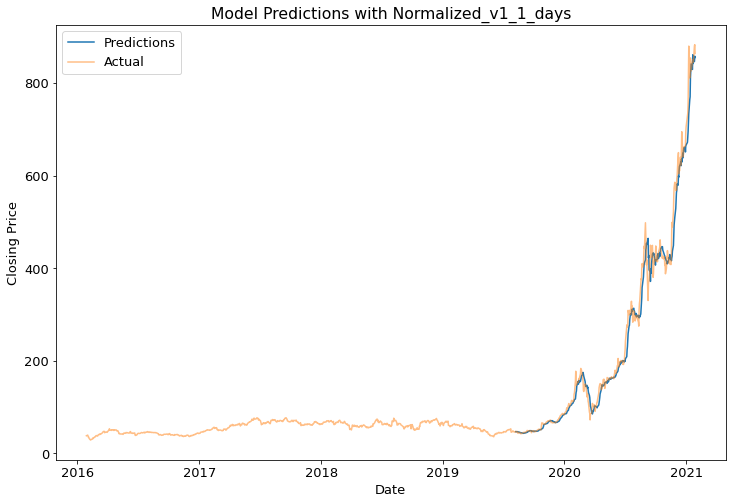

<Figure size 432x288 with 0 Axes>

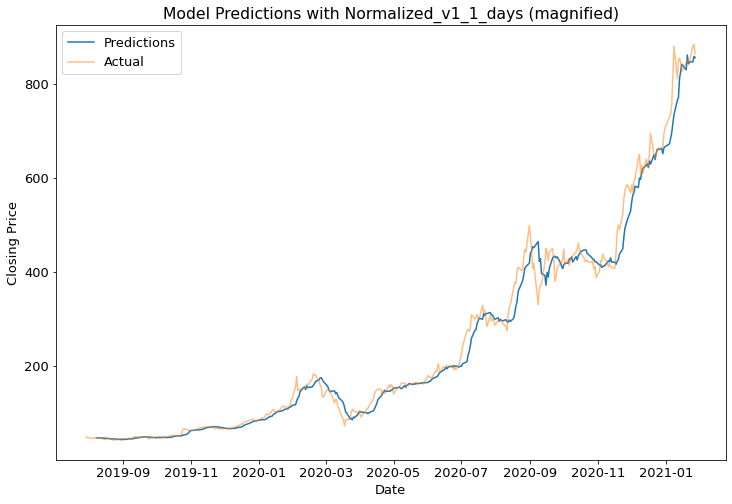

FOR THIS VERSION OF THE MODEL, THE AVERAGE LOSS OVER 10 RUNS IS 22.989440507293455


<Figure size 432x288 with 0 Axes>

In [88]:
df_path = "/content/tesla-stock-data.csv"
window_size = 7 
out_size = 1 
target = 'Close'

test_size=0.3
training_batch_size = 16
test_batch_size = 1

normalize = False
num_epochs = 5
lr = 0.000005
optim_type = "SGD"
weight_decay = 0
save_path = f"Normalized_v1_{out_size}_days"

main(df_path,
     window_size,
     out_size,
     target,
     test_size,
     training_batch_size,
     test_batch_size,
     normalize,
     num_epochs,
     lr,
     save_path,
     optim_type,
     weight_decay
     )



The general structure of the neural network used for training is a 2 layer neural net:

Input (7) - Dense(10) - RELU - Dense(1) - Output(1)

Experiment Results (Unnormalized):
-----------------------------------------
1. Parameters :
  * SGD with momentum
  * 10 epochs
  * unnormalized
  * RMSE
  * lr - 0.0001
  
  We get an averaged test loss of 11.559852639605994.



2. Parameters :
  * SGD with momentum
  * 10 epochs
  * unnormalized
  * RMSE
  * lr - 0.00001
  
  We get an averaged test loss of 15.655083044918916


3. Parameters :
  * SGD with momentum
  * 10 epochs
  * unnormalized
  * RMSE
  * weight decay (L2) - 0.01
  * lr - 0.0001
  
  We get an averaged test loss of 12.245280777388832

4. Parameters :
  * ADAM
  * 10 epochs
  * unnormalized
  * RMSE
  * lr - 0.0001
  
  We get an averaged test loss of 125.97540926785484

5. Parameters :
  * ADAM
  * 20 epochs
  * unnormalized
  * RMSE
  * lr - 0.001
  
  We get an averaged test loss of 14.332120224583054


6. Parameters :
  * ADAM
  * 20 epochs
  * unnormalized
  * RMSE
  * lr - 0.0001
  * weight decay (L2) - 0.01
  
  We get an averaged test loss of 46.89324450016691

7. Parameters :
  * ADAM
  * 20 epochs
  * unnormalized
  * RMSE
  * lr - 0.001
  * weight decay (L2) - 0.01
  
  We get an averaged test loss of 14.525197051236958



Experiment Results (Normalized):

1. Parameters :
  * SGD with momentum
  * 10 epochs
  * unnormalized
  * RMSE
  * lr - 0.0001
We get an averaged test loss of 1.841047557622467 (Note that this is not very reflective of model's power since RMSE calculated based on normalized values). In reality the loss is much higher than the unnormalized version, with the same parameters. You can also see this by comparing UnNormalized_v1.png and Normalized_v1.png

# 7. Closing Remarks

Even though some of the experiments showed promising results, with low RMSE scores, the model's predictive powers are not actually that good. 

Some of the models with low RMSE scores are actually just predicting the value at time “t+1” using the ground truth value at time “t” as its prediction. Take the period between 2020 and 2021 as an example from the figure below:



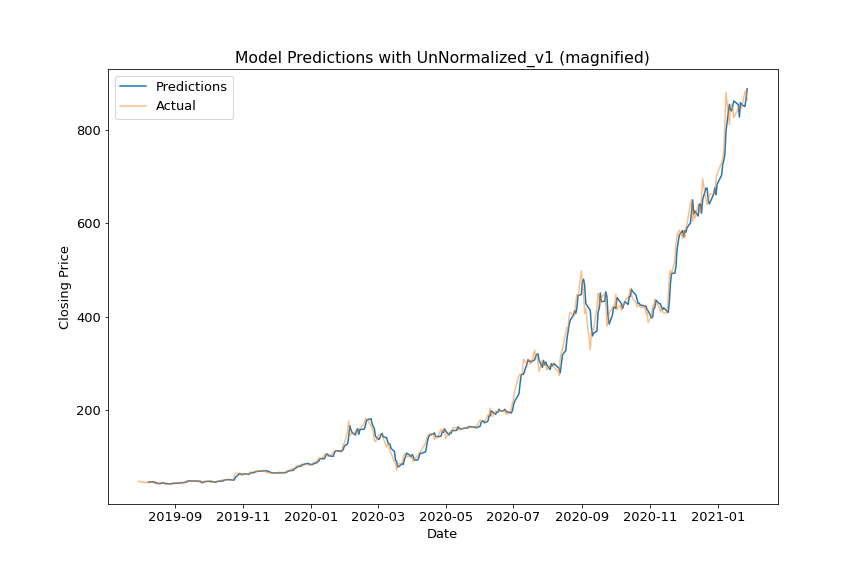

The predictions for that time period are off by a day or two, and it's highly likely that this is caused by the persistence model. 

[This article](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) talks a lot about such pitfalls, and alternative ways to measure model's predictive performance. But for now, this is out of the scope for this notebook.